# 2_Exploratory Data Analysis

In [5]:
import numpy as np
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm

In [6]:
orbital_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\all_satellite_orbitals.csv"
maneuver_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\cleaned_maneuvers.csv"

In [7]:
df_orbital = pd.read_csv(orbital_file)
df_maneuver = pd.read_csv(maneuver_file)

# Plots

In [17]:
def plot_multiple_variables_presentation_grid(df_orbital, df_maneuver, satellite_name, variables_list,
                                               start_epoch=None, end_epoch=None, config=None,
                                               save_path=None, show_markers=False, figsize=(18, 10)):
    """
    Plot multiple orbital variables in a 2x3 grid layout.
    Styled to match precision-recall comparison plots.
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    from matplotlib import rcParams
    import numpy as np

    # Presentation-ready font configuration
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
    
    # Font sizes optimized for presentations
    if save_path is None:
        font_size = 14
        title_size = 14
        dpi = 100
    else:
        font_size = 11
        title_size = 13
        dpi = 300

    rcParams.update({
        'font.size': font_size,
        'axes.titlesize': title_size,
        'axes.labelsize': font_size,
        'xtick.labelsize': font_size - 1,
        'ytick.labelsize': font_size - 1,
        'legend.fontsize': font_size,
    })

    # Styled configuration matching precision-recall plots
    default_config = {
        "line_color_orbital": "#000000",  
        "line_color_maneuvers": "#D55E00",  
        "grid_color": "lightgrey",
        "grid_alpha": 0.3,
        "spine_color": "#333333",
        "tick_color": "#333333"
    }
    
    config = config or default_config

    # Prepare data
    df_orbital = df_orbital.copy()
    df_orbital['eccentricity_scaled'] = df_orbital['eccentricity'] * 1e4

    default_units = {
        'Brouwer mean motion': 'Mean Motion (rad/s)',
        'eccentricity_scaled': 'Eccentricity (×10-4)',
        'eccentricity': 'Eccentricity (×10-4)',
        'argument of perigee': 'Argument of Perigee (rad)',
        'inclination': 'Inclination (rad)',
        'mean anomaly': 'Mean Anomaly (rad)',
        'right ascension': 'Right Ascension (rad)'
    }

    # Filter satellite data
    df_sat_orbital = df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    df_sat_maneuver = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite_name].copy()

    # Convert dates
    df_sat_orbital['epoch_date'] = pd.to_datetime(df_sat_orbital['epoch_date'])
    if not df_sat_maneuver.empty:
        df_sat_maneuver['start_date'] = pd.to_datetime(df_sat_maneuver['start_date'])

    # Apply date filters
    if start_epoch:
        start_epoch = pd.to_datetime(start_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] >= start_epoch]
        if not df_sat_maneuver.empty:
            df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] >= start_epoch]
    if end_epoch:
        end_epoch = pd.to_datetime(end_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] <= end_epoch]
        if not df_sat_maneuver.empty:
            df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] <= end_epoch]

    # Determine grid layout
    n_vars = len(variables_list)
    if n_vars <= 3:
        nrows, ncols = 1, n_vars
        figsize = (6 * n_vars, 6)
    elif n_vars <= 6:
        nrows, ncols = 2, 3
        figsize = figsize  # Use provided figsize
    else:
        # For more than 6 variables, use a larger grid
        nrows = int(np.ceil(n_vars / 3))
        ncols = 3
        figsize = (18, 5 * nrows)

    # Date format logic
    if len(df_sat_orbital) >= 2:
        duration = (df_sat_orbital['epoch_date'].max() - df_sat_orbital['epoch_date'].min()).days
        if duration > 365 * 2:
            date_fmt = '%Y'
        elif duration > 180:
            date_fmt = '%Y-%m'
        elif duration > 30:
            date_fmt = '%Y-%m-%d'
        else:
            date_fmt = '%m-%d'
    else:
        date_fmt = '%Y-%m'

    # Create figure and subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, 
                            gridspec_kw={'hspace': 0.35, 'wspace': 0.25})
    
    # Handle single row case
    if nrows == 1:
        axes = axes.reshape(1, -1) if n_vars > 1 else np.array([[axes]])
    
    # Flatten axes for easy iteration
    axes_flat = axes.flatten()

    # Store legend elements
    legend_elements = {}

    # Plot each variable
    for i, variable in enumerate(variables_list):
        ax = axes_flat[i]
        
        # Handle eccentricity scaling
        if variable == 'eccentricity':
            y_data = df_sat_orbital['eccentricity_scaled']
            variable_key = 'eccentricity_scaled'
        else:
            y_data = df_sat_orbital[variable]
            variable_key = variable

        # Plot orbital data
        line, = ax.plot(df_sat_orbital['epoch_date'], y_data,
                       color=config["line_color_orbital"],
                       linewidth=1.5,
                       alpha=0.8,
                       label='Orbital Elements')

        # Add maneuver timestamps
        if not df_sat_maneuver.empty:
            for _, row in df_sat_maneuver.iterrows():
                maneuver_line = ax.axvline(x=row['start_date'],
                                         color=config["line_color_maneuvers"],
                                         linestyle="--",
                                         linewidth=1.5,
                                         alpha=0.7)
            
            # Store legend elements (only once)
            if i == 0:
                legend_elements["Orbital Elements"] = line
                legend_elements["Maneuver Timestamps"] = maneuver_line

        # Styling consistent with precision-recall plots
        ax.set_title(default_units.get(variable_key, variable.title()), 
                    fontweight='bold', pad=15)
        
        # Grid styling
        ax.grid(True, linestyle='--', alpha=config["grid_alpha"], 
               color=config["grid_color"], linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Spine styling
        for spine in ax.spines.values():
            spine.set_color(config["spine_color"])
            spine.set_linewidth(0.8)
        
        # Tick styling
        ax.tick_params(axis='both', colors=config["tick_color"], labelsize=font_size-1)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        
        # Date formatting for x-axis
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Hide empty subplots
    for j in range(len(variables_list), len(axes_flat)):
        axes_flat[j].set_visible(False)

    # Add main title
    fig.suptitle(f"Orbital Elements - {satellite_name}", 
                fontsize=title_size + 2, fontweight='bold', y=0.98)

    # Add legend if we have maneuvers - positioned at bottom to avoid overlap
    if legend_elements:
        fig.legend(
            handles=list(legend_elements.values()),
            labels=list(legend_elements.keys()),
            loc="lower center",
            bbox_to_anchor=(0.5, -0.02),
            ncol=len(legend_elements),
            frameon=True,
            fancybox=True,
            shadow=True,
            fontsize=font_size
        )

    # Set date limits if specified
    if start_epoch and end_epoch:
        for ax in axes_flat[:len(variables_list)]:
            ax.set_xlim(start_epoch, end_epoch)

    # Adjust layout - more space at bottom for legend, less at top
    plt.tight_layout(rect=[0, 0.08, 1, 0.94])

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")

    plt.show()

In [7]:
def plot_acf_pacf(df_orbital, satellite_name, variable, lags=30, figsize=(16, 4), 
                  save_path=None, adjust_y_axis=True, dpi=300):
    """
    Plot ACF and PACF for a selected satellite and variable.
    
    Parameters:
    -----------
    df_orbital : pandas DataFrame
        The dataframe containing orbital data for multiple satellites
    satellite_name : str
        The name of the satellite to filter for
    variable : str
        The variable/column name to analyze
    lags : int, default=30
        Number of lags to include in the plots
    figsize : tuple, default=(16, 4)
        Size of the figure (width, height)
    save_path : str or None, default=None
        Path to save the figure. If None, the figure is not saved
    adjust_y_axis : bool, default=True
        Whether to adjust the y-axis limits based on the data
    dpi : int, default=300
        Resolution for the saved figure
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing the plots
    """
    # Filter the dataframe for the specified satellite
    df_filtered =df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    
    # Check if the filtered dataframe is empty
    if df_filtered.empty:
        raise ValueError(f"No data found for satellite '{satellite_name}'")
    
    # Check if the variable exists in the dataframe
    if variable not in df_filtered.columns:
        raise ValueError(f"Variable '{variable}' not found in the dataframe")
    
    # Get the data series for the specified variable
    data_series = df_filtered[variable]
    
    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    
    # Calculate ACF and PACF values
    acf_values = sm.tsa.acf(data_series, nlags=lags)
    pacf_values = sm.tsa.pacf(data_series, nlags=lags)
    
    # Plot ACF - use the statsmodels plot_acf function with the specified axis
    sm.graphics.tsa.plot_acf(data_series, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title(f"Autocorrelation Function (ACF)")
    axes[0].set_xlabel(f"Lag (days)")
    axes[0].set_ylabel("Correlation coefficient")
    
    # Plot PACF - use the statsmodels plot_pacf function with the specified axis
    sm.graphics.tsa.plot_pacf(data_series, lags=lags, ax=axes[1], alpha=0.05)
    axes[1].set_title(f"Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel(f"Lag (days)")
    axes[1].set_ylabel("Correlation coefficient")
    
    # Adjust y-axis limits if requested
    if adjust_y_axis:
        # Find min and max values, adding a small buffer
        min_val = min(min(acf_values), min(pacf_values)) - 0.05
        max_val = max(max(acf_values), max(pacf_values)) + 0.05
        
        # Ensure the range is at least 0.2 to avoid too narrow plots
        if max_val - min_val < 0.2:
            mean = (max_val + min_val) / 2
            min_val = mean - 0.1
            max_val = mean + 0.1
        
        # Set the limits but don't exceed the standard -1 to 1 range
        y_min = max(-1, min_val)
        y_max = min(1, max_val)
        
        axes[0].set_ylim(y_min, y_max)
        axes[1].set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

In [29]:
def plot_variable_with_maneuvers(df_orbital, df_maneuver, satellite_name, variable,
                              start_epoch=None, end_epoch=None, units=None,
                              config=None, save_path=None, show_markers=False):
    
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    from matplotlib import rcParams

    # Better font configuration for saved figures
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
    
    # Figure size and DPI settings that work well for both display and saving
    if save_path is None:
        fig_size = (10, 5)
        font_size = 11
        dpi = 100
    else:
        fig_size = (8, 4)  # Better size ratio for Word documents
        font_size = 12     # Slightly larger for readability in documents
        dpi = 300
    
    # Set font sizes
    rcParams.update({
        'font.size': font_size,
        'axes.titlesize': font_size + 1,
        'axes.labelsize': font_size,
        'xtick.labelsize': font_size - 1,
        'ytick.labelsize': font_size - 1,
        'legend.fontsize': font_size - 1,
    })
    
    default_units = {
        'Brouwer mean motion': 'rad/s',
        'eccentricity': '',
        'argument of perigee': 'rad',
        'inclination': 'rad',
        'mean anomaly': 'rad',
        'right ascension': 'rad'
    }
    
    default_config = {
        "line_color_orbital": "#000000",
        "line_color_residuals": "orange",
        "line_color_maneuvers": "#D55E00",
        "tick_color": "black",
        "frame_color": "#cccccc",
        "marker": "o" if show_markers else None,
        "marker_size": 4,
        "marker_freq": 20  # Show marker every N points
    }
    
    if config is None:
        config = default_config
    else:
        # Merge user config with defaults
        for key, value in default_config.items():
            if key not in config:
                config[key] = value
    
    # Handle marker settings
    if show_markers and "marker" not in config:
        config["marker"] = "o"
        config["marker_size"] = 4
    
    df_sat_orbital = df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    df_sat_maneuver = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite_name].copy()
    
    if df_sat_orbital.empty:
        print(f"No orbital data found for {satellite_name}")
        return
    
    if df_sat_maneuver.empty:
        print(f"No maneuver data found for {satellite_name}")
    
    # Ensure datetime type
    df_sat_orbital['epoch_date'] = pd.to_datetime(df_sat_orbital['epoch_date'])
    if not df_sat_maneuver.empty:
        df_sat_maneuver['start_date'] = pd.to_datetime(df_sat_maneuver['start_date'])
    
    # Apply zoom filters
    if start_epoch:
        start_epoch = pd.to_datetime(start_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] >= start_epoch]
        if not df_sat_maneuver.empty:
            df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] >= start_epoch]
    
    if end_epoch:
        end_epoch = pd.to_datetime(end_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] <= end_epoch]
        if not df_sat_maneuver.empty:
            df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] <= end_epoch]
    
    # Create the figure with appropriate size
    fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)
    
    # If showing markers but we have many data points, show them less frequently
    if show_markers and len(df_sat_orbital) > config["marker_freq"]:
        # Plot line without markers
        plt.plot(df_sat_orbital['epoch_date'], df_sat_orbital[variable],
                 color=config["line_color_orbital"],
                 linewidth=0.9)
        
        # Add markers at reduced frequency
        marker_data = df_sat_orbital.iloc[::config["marker_freq"]]
        plt.plot(marker_data['epoch_date'], marker_data[variable],
                 label=variable,
                 color=config["line_color_orbital"],
                 marker=config["marker"],
                 markersize=config["marker_size"],
                 linestyle='none')
    else:
        # Plot time series with or without markers
        plt.plot(df_sat_orbital['epoch_date'], df_sat_orbital[variable],
                 label=variable,
                 color=config["line_color_orbital"],
                 linewidth=0.9,
                 marker=config["marker"],
                 markersize=config.get("marker_size", 4) if show_markers else None,
                 markevery=config.get("marker_freq", 20) if show_markers else None)
    
    # Vertical lines for maneuvers
    maneuver_plotted = False
    if not df_sat_maneuver.empty:
        for i, row in df_sat_maneuver.iterrows():
            plt.axvline(
                x=row['start_date'],
                color=config["line_color_maneuvers"],
                alpha=0.8,
                linestyle="--",
                linewidth=1,
                label="Manoeuvre Timestamp" if not maneuver_plotted else ""
            )
            maneuver_plotted = True
    
    # Axis formatting
    unit = units if units else default_units.get(variable, "")
    plt.ylabel(unit, color=config["tick_color"])
    plt.xticks(color=config["tick_color"])
    plt.yticks(color=config["tick_color"])
    
    
    # Legend positioning - always at top left
    #plt.legend(loc="upper left", frameon=False)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False)
    
    # Smart date formatting
    if len(df_sat_orbital) >= 2:
        t_start = df_sat_orbital['epoch_date'].min()
        t_end = df_sat_orbital['epoch_date'].max()
        duration = (t_end - t_start).days
        
        if duration > 365*2:
            date_fmt = '%Y'
        elif duration > 180:
            date_fmt = '%Y-%m'
        elif duration > 30:
            date_fmt = '%Y-%m-%d'
        else:
            date_fmt = '%m-%d %H:%M'
        
        # Force specific date format for your case
        if duration > 180 and duration < 500:  # ~1-1.5 years
            date_fmt = '%Y-%m'
            
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
    
    # Frame color
    for spine in ax.spines.values():
        spine.set_color(config["frame_color"])
    
    # Set x-limits explicitly if provided
    if start_epoch is not None and end_epoch is not None:
        plt.xlim(start_epoch, end_epoch)
    
    # Set y-limits with a small margin
    y_min = df_sat_orbital[variable].min()
    y_max = df_sat_orbital[variable].max()
    y_range = y_max - y_min
    margin = max(y_range * 0.05, 0.000001)  # At least 0.000001 or 5% of range
    plt.ylim(y_min - margin, y_max + margin)
    
    # Tight layout for better use of space
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()
    plt.close()

In [476]:
#Plot several variables at the same time
def plot_multiple_satellite_variables(df_orbital, df_maneuver, satellite_name, variables, start_epoch=None, end_epoch=None):
    """
    Calls `plot_satellite_variable_with_maneuvers` for each variable in the list.
    This generates one plot per variable.

    Args:
        df_orbital (pd.DataFrame): The orbital dataset.
        df_maneuver (pd.DataFrame): The maneuver dataset.
        satellite_name (str): The name of the satellite to filter.
        variables (list or set of str): A list or set of orbital parameters to plot.
        start_epoch (str or None): Start date-time for zooming in (format: 'YYYY-MM-DD HH:MM:SS'). If None, full range is used.
        end_epoch (str or None): End date-time for zooming in (format: 'YYYY-MM-DD HH:MM:SS'). If None, full range is used.
    """
    for variable in variables:
        print(f"\nPlotting {variable} for {satellite_name}...\n")
        plot_variable_with_maneuvers(df_orbital, df_maneuver, satellite_name, variable, start_epoch, end_epoch)

In [478]:
def plot_multivariable_with_maneuvers(df_orbital, df_maneuver, satellite_name, variables,
                                      start_epoch, end_epoch, save_path=None):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    
    # Font and layout settings
    plt.rcParams.update({
        'font.size': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans']
    })

    df = df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    df['epoch_date'] = pd.to_datetime(df['epoch_date'])
    df = df[(df['epoch_date'] >= pd.to_datetime(start_epoch)) & (df['epoch_date'] <= pd.to_datetime(end_epoch))]

    maneuvers = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite_name].copy()
    maneuvers['start_date'] = pd.to_datetime(maneuvers['start_date'])
    maneuvers = maneuvers[(maneuvers['start_date'] >= pd.to_datetime(start_epoch)) & 
                          (maneuvers['start_date'] <= pd.to_datetime(end_epoch))]

    # Setup figure and axes
    fig, axes = plt.subplots(len(variables), 1, figsize=(8, 10), sharex=True, dpi=300)

    for i, var in enumerate(variables):
        ax = axes[i]
        ax.plot(df['epoch_date'], df[var], color='deepskyblue', linewidth=0.9)

        for _, row in maneuvers.iterrows():
            ax.axvline(row['start_date'], color='navy', linestyle='--', linewidth=1, alpha=0.8)

        #ax.set_ylabel(var, rotation=90, ha='right', va='center', labelpad=20)

        # Style
        ax.grid(False, axis='y', linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Format the x-axis only at the bottom
    axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    fig.tight_layout(h_pad=1.0)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    plt.close()

# Exploration Plots

C:\Users\Suare\AppData\Local\Temp\ipykernel_39760\548771151.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.94])


Figure saved to: Section3.Figure1.png


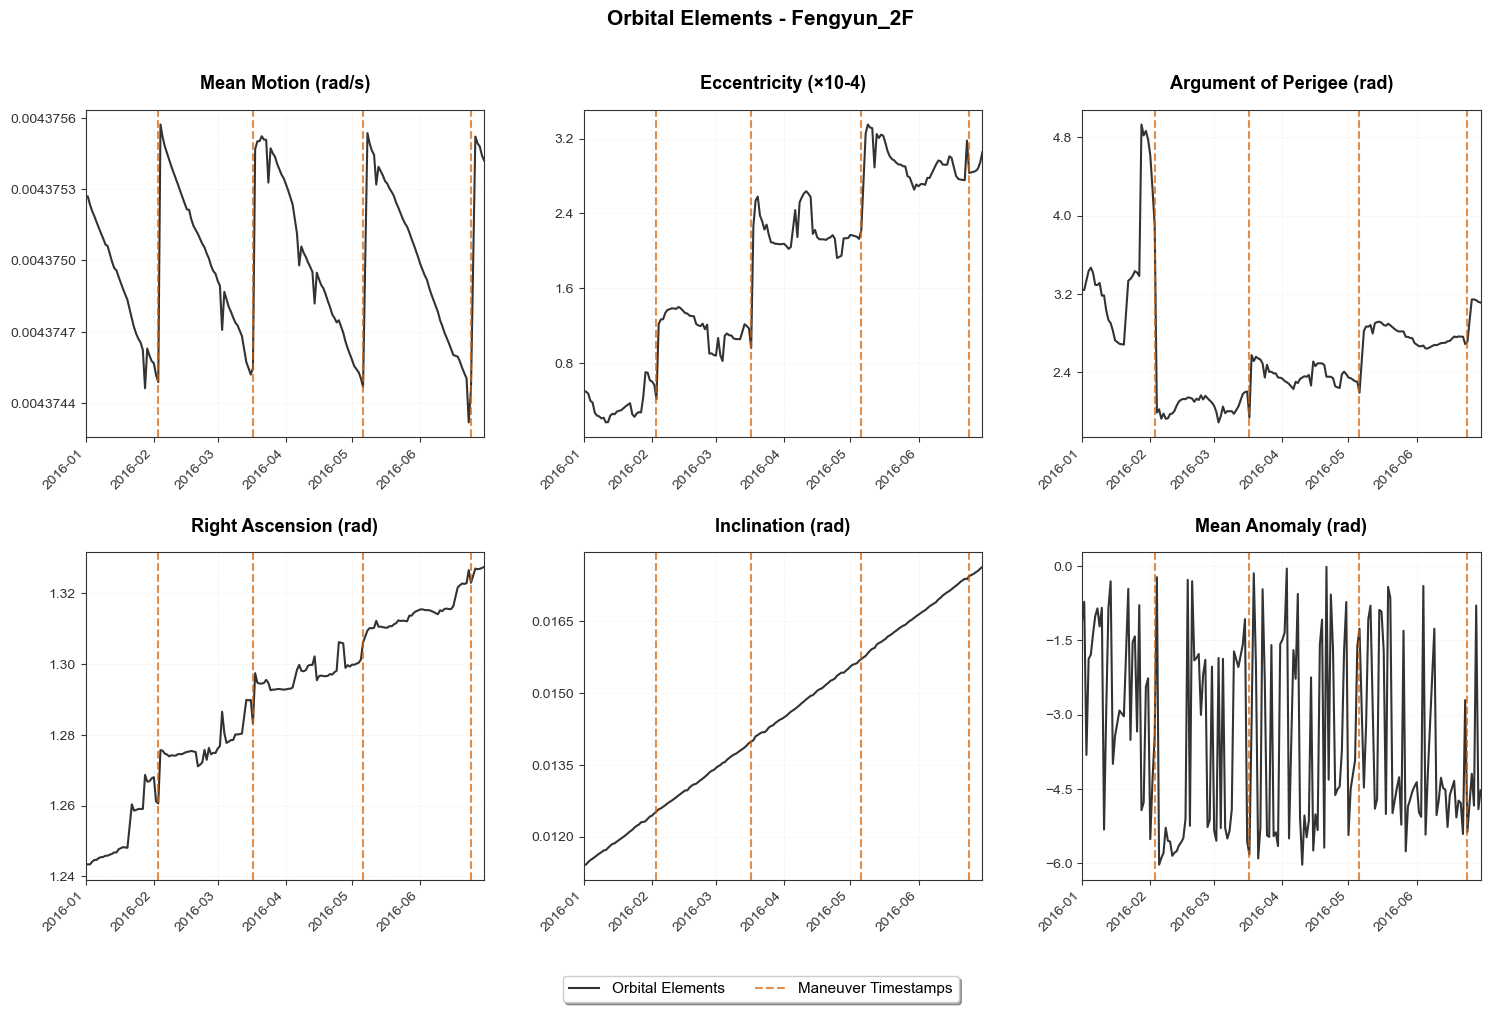

In [19]:
variables_to_plot =  ["Brouwer mean motion", "eccentricity_scaled", "argument of perigee","right ascension", "inclination", "mean anomaly"]
plot_multiple_variables_presentation_grid(
    df_orbital, df_maneuver, 
    satellite_name="Fengyun_2F",
    variables_list=variables_to_plot,
    start_epoch="2016-01-01",
    end_epoch="2016-06-30",
    save_path="Section3.Figure1.png")

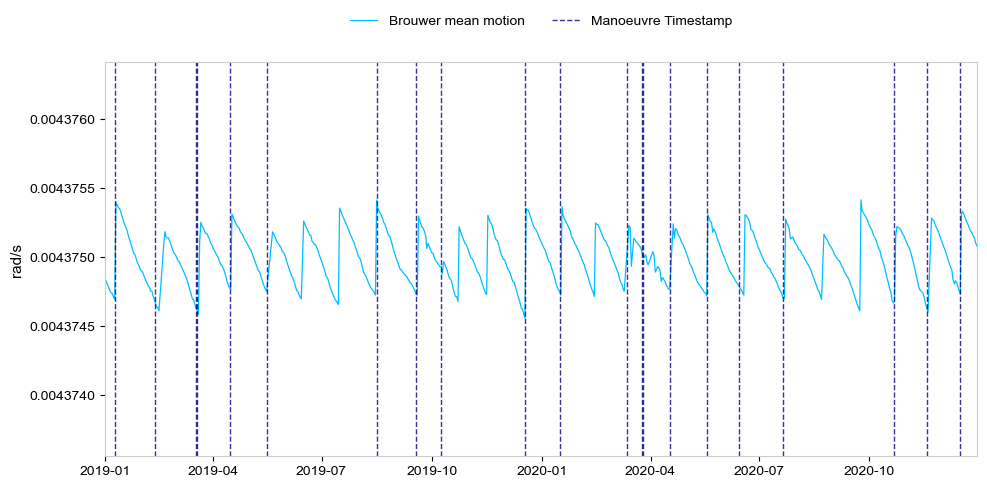

In [484]:
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Fengyun_4A", "Brouwer mean motion", 
                             "2019-01-01","2020-12-30", save_path=None)


Plotting Brouwer mean motion for Fengyun_4A...



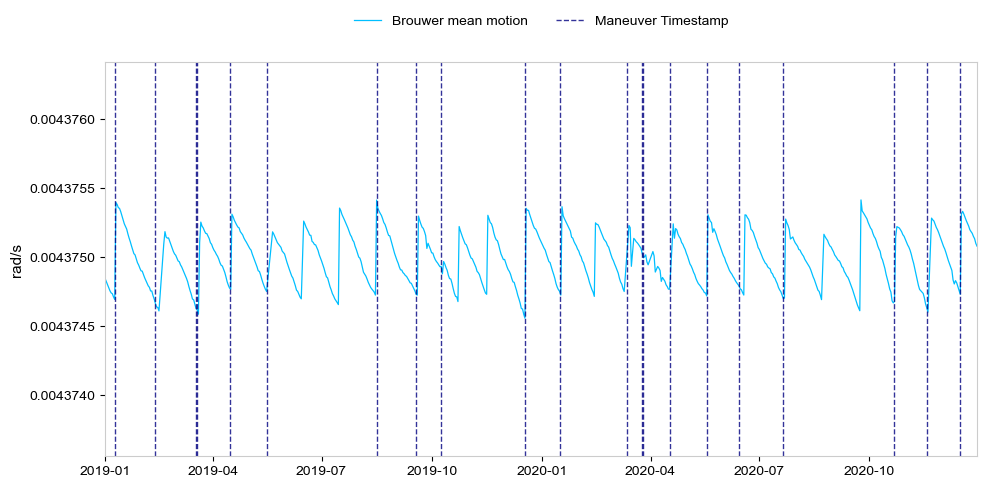


Plotting eccentricity for Fengyun_4A...



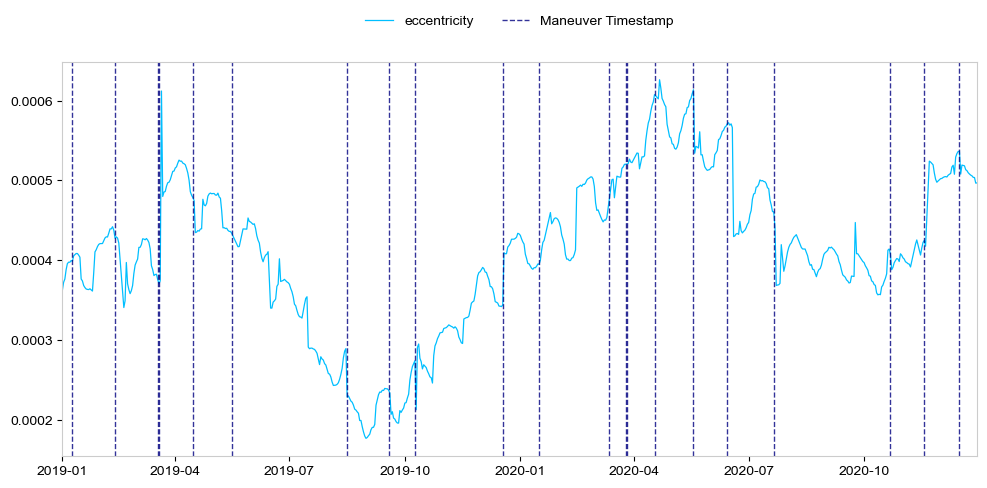


Plotting argument of perigee for Fengyun_4A...



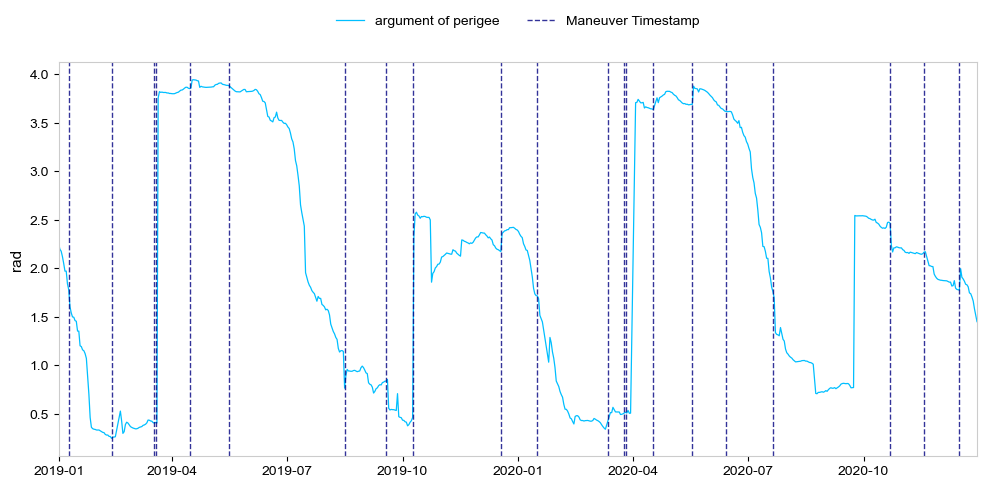


Plotting right ascension for Fengyun_4A...



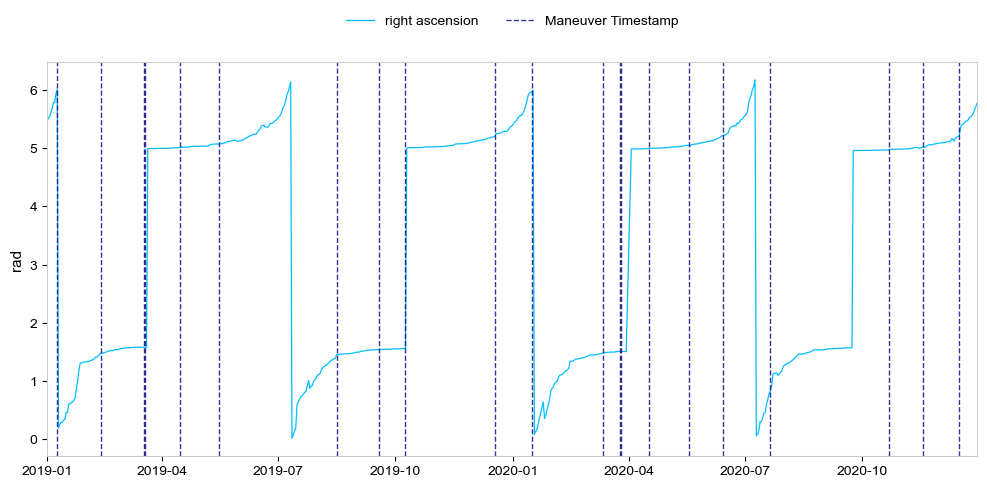


Plotting inclination for Fengyun_4A...



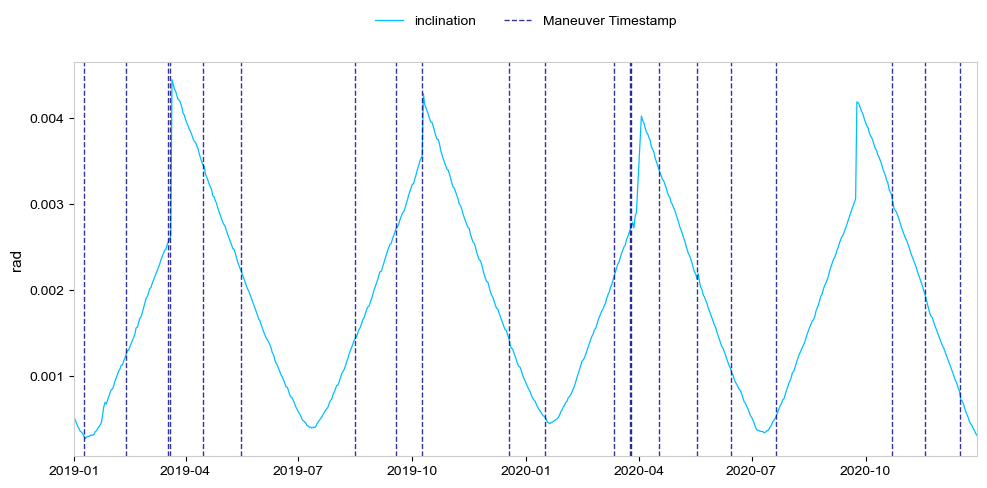


Plotting mean anomaly for Fengyun_4A...



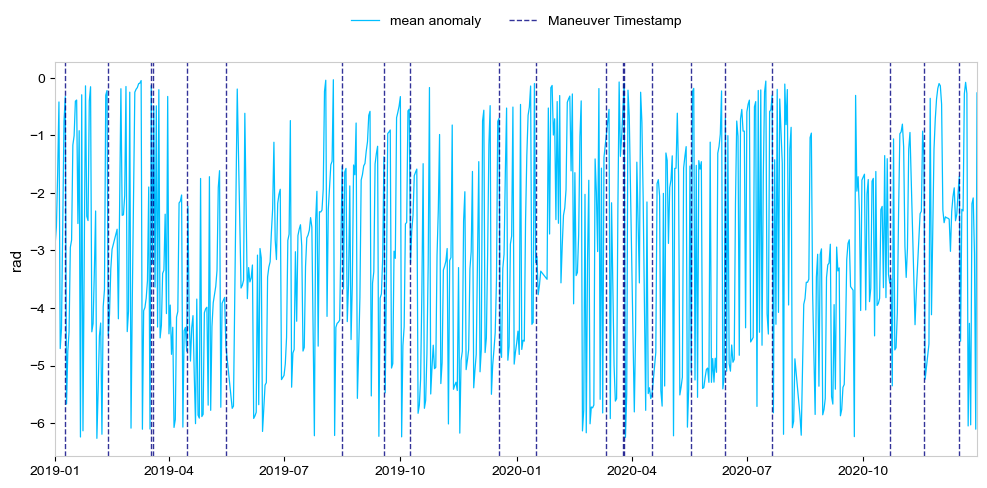

In [472]:
plot_multiple_satellite_variables(df_orbital, df_maneuver, "Fengyun_4A", variables_to_plot1,"2019-01-01","2020-12-30")

# Summary Table

In [21]:
# Function to create the summary table
def create_satellite_summary_table(df_orbital: pd.DataFrame,
                                   df_maneuver: pd.DataFrame,
                                   satellites):
    """
    Build a per-satellite summary (rows = metrics, columns = satellites).

    Required columns:
      df_orbital: ['satellite_name', 'epoch_date']
      df_maneuver: ['OrbitalKeyName', ('start_date' or 'start_datetime'), optional 'end_datetime', optional 'duration_minutes']
    """
    # ---- Safe copies & datetime parsing (no mutation of caller data) ----
    orb = df_orbital.copy()
    man = df_maneuver.copy()

    orb['epoch_date'] = pd.to_datetime(orb['epoch_date'], errors='coerce')
    if 'start_date' in man.columns:
        man['start_date'] = pd.to_datetime(man.get('start_date'), errors='coerce')
    if 'start_datetime' in man.columns:
        man['start_datetime'] = pd.to_datetime(man.get('start_datetime'), errors='coerce')
    if 'end_datetime' in man.columns:
        man['end_datetime'] = pd.to_datetime(man.get('end_datetime'), errors='coerce')

    # Choose a unified start timestamp column for maneuvers
    if 'start_date' in man.columns:
        man['start_dt'] = man['start_date']
    elif 'start_datetime' in man.columns:
        man['start_dt'] = man['start_datetime']
    else:
        man['start_dt'] = pd.NaT  # fallback; will yield empty per-sat

    # Filter maneuvers to overlap the *global* orbital date range (as in your code)
    start_range = orb['epoch_date'].min()
    end_range = orb['epoch_date'].max()
    if 'end_datetime' in man.columns:
        man = man[(man['end_datetime'] >= start_range) & (man['start_dt'] <= end_range)]
    else:
        # If no end, keep ones that start within the overall range
        man = man[(man['start_dt'] >= start_range) & (man['start_dt'] <= end_range)]

    metrics = [
        "Time Period",
        "Number of Records",
        "Missing Timestamps",
        "Number of Maneuvers",
        "Maneuvers Per Year",
        "Median Days Between Maneuvers",
        "Maneuvers Within 6 Days",
        "Max Duration of Maneuvers (hours)",
        "Maneuvers on Missing Timestamps (%)",
        "Same Day Maneuvers",
        "Duplicate Maneuvers",
    ]

    summary = {}

    for sat in satellites:
        sat_orb = orb.loc[orb['satellite_name'] == sat].copy()
        sat_man = man.loc[man['OrbitalKeyName'] == sat].copy()

        if sat_orb.empty:
            # Skip completely missing satellites, matching your original behaviour
            print(f"No orbital data found for {sat}")
            continue

        out = {}

        # 1) Time Period
        min_d = sat_orb['epoch_date'].min()
        max_d = sat_orb['epoch_date'].max()
        out["Time Period"] = f"{min_d.date()} to {max_d.date()}"

        # 2) Number of Records
        out["Number of Records"] = int(len(sat_orb))

        # 3) Missing Timestamps (daily)
        full_days = pd.date_range(min_d.normalize(), max_d.normalize(), freq='D')
        have_days = set(sat_orb['epoch_date'].dt.normalize().unique())
        missing_days = set(full_days.normalize()) - have_days
        out["Missing Timestamps"] = int(len(missing_days))

        # 4) Number of Maneuvers
        n_man = int(sat_man['start_dt'].notna().sum()) if not sat_man.empty else 0
        out["Number of Maneuvers"] = n_man

        # 5) Maneuvers Per Year
        if n_man >= 1:
            smin, smax = sat_man['start_dt'].min(), sat_man['start_dt'].max()
            total_years = (smax - smin).days / 365.25 if pd.notna(smin) and pd.notna(smax) else 0
            out["Maneuvers Per Year"] = round(n_man / total_years, 2) if total_years > 0 else "N/A"
        else:
            out["Maneuvers Per Year"] = 0

        # 6) Median Days Between Maneuvers
        if n_man > 1:
            diffs = sat_man.sort_values('start_dt')['start_dt'].diff().dropna()
            diffs_days = diffs.dt.total_seconds() / (24 * 3600)
            out["Median Days Between Maneuvers"] = round(diffs_days.median(), 1)
        else:
            out["Median Days Between Maneuvers"] = "N/A"

        # 7) Maneuvers Within 6 Days (based on successive diffs)
        if n_man > 1:
            out["Maneuvers Within 6 Days"] = int((diffs_days <= 6).sum())
        else:
            out["Maneuvers Within 6 Days"] = 0

        # 8) Max Duration of Maneuvers (hours)
        if not sat_man.empty and 'duration_minutes' in sat_man.columns and sat_man['duration_minutes'].notna().any():
            out["Max Duration of Maneuvers (hours)"] = round(sat_man['duration_minutes'].max() / 60, 1)
        else:
            out["Max Duration of Maneuvers (hours)"] = "N/A"

        # 9) Maneuvers on Missing Timestamps (%)
        if n_man > 0 and len(missing_days) > 0:
            man_days = sat_man['start_dt'].dt.normalize()
            maneuvers_on_missing = int(man_days.isin(missing_days).sum())
            out["Maneuvers on Missing Timestamps (%)"] = round((maneuvers_on_missing / n_man) * 100, 1)
        else:
            out["Maneuvers on Missing Timestamps (%)"] = 0.0

        # 10) Same Day Maneuvers & 11) Duplicate Maneuvers
        if n_man > 0:
            per_day = sat_man.groupby(sat_man['start_dt'].dt.normalize()).size()
            same_day = int((per_day > 1).sum())
            duplicates = int(per_day[per_day > 1].sum() - same_day)
            out["Same Day Maneuvers"] = same_day
            out["Duplicate Maneuvers"] = duplicates
        else:
            out["Same Day Maneuvers"] = 0
            out["Duplicate Maneuvers"] = 0

        # Ensure all metrics exist (keeps consistent ordering)
        summary[sat] = {m: out.get(m, "N/A") for m in metrics}

    return pd.DataFrame(summary)

In [25]:
satellites = ["Sentinel_3A", "Fengyun_2F", "Fengyun_2E", "Jason_3", "Sentinel_3B", "CryoSat_2"]
# Generate the summary table
summary_table = create_satellite_summary_table(df_orbital, df_maneuver, satellites)

In [27]:
summary_table

,Sentinel_3A,Fengyun_2F,Fengyun_2E,Jason_3,Sentinel_3B,CryoSat_2
Time Period,2016-03-04 to 2022-09-29,2012-09-06 to 2022-01-11,2011-03-13 to 2018-10-21,2016-01-31 to 2022-10-03,2018-05-10 to 2022-09-29,2010-04-25 to 2022-09-28
Number of Records,2385,2985,2375,2410,1582,4308
Missing Timestamps,16,430,405,28,22,232
Number of Maneuvers,64,68,48,42,56,168
Maneuvers Per Year,9.67,7.3,6.33,6.38,12.63,13.47
Median Days Between Maneuvers,31.0,49.0,49.0,51.0,21.0,26.0
Maneuvers Within 6 Days,9,2,0,13,17,29
Max Duration of Maneuvers (hours),2.7,96.0,48.0,3.3,2.6,9.8
Maneuvers on Missing Timestamps (%),1.6,22.1,20.8,11.9,1.8,6.5
Same Day Maneuvers,0,1,0,0,1,6


# Report Plots

Figure saved to figures/missingvalues_fengyun.png


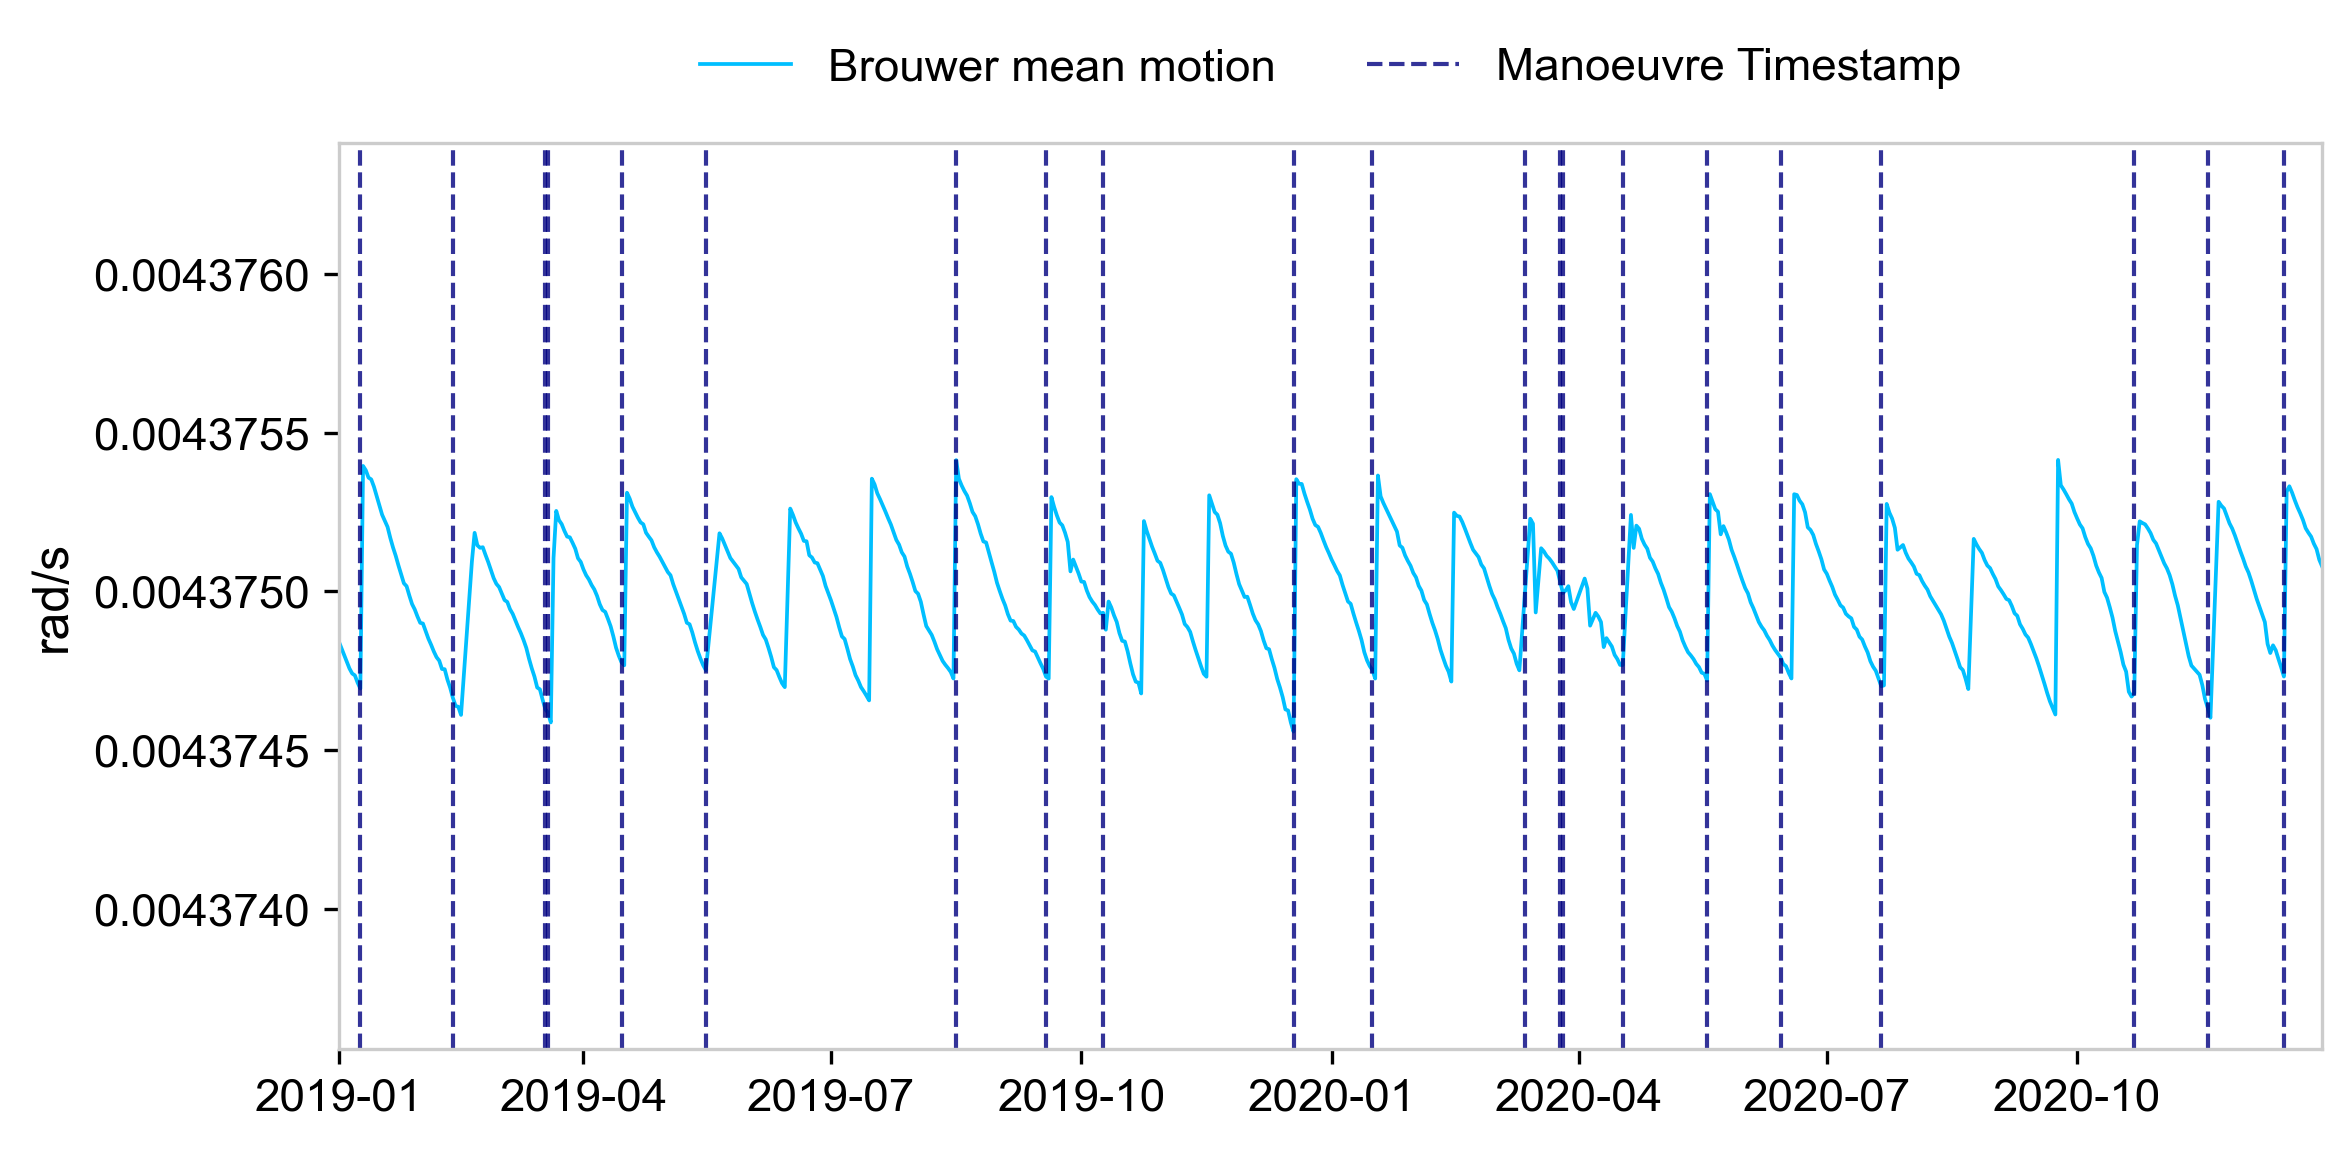

In [488]:
#Missing Values
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Fengyun_4A", "Brouwer mean motion", "2019-01-01","2020-12-30", 
                             save_path="figures/multivariable_fengyun.png")

Figure saved to Section1_Figure2.png


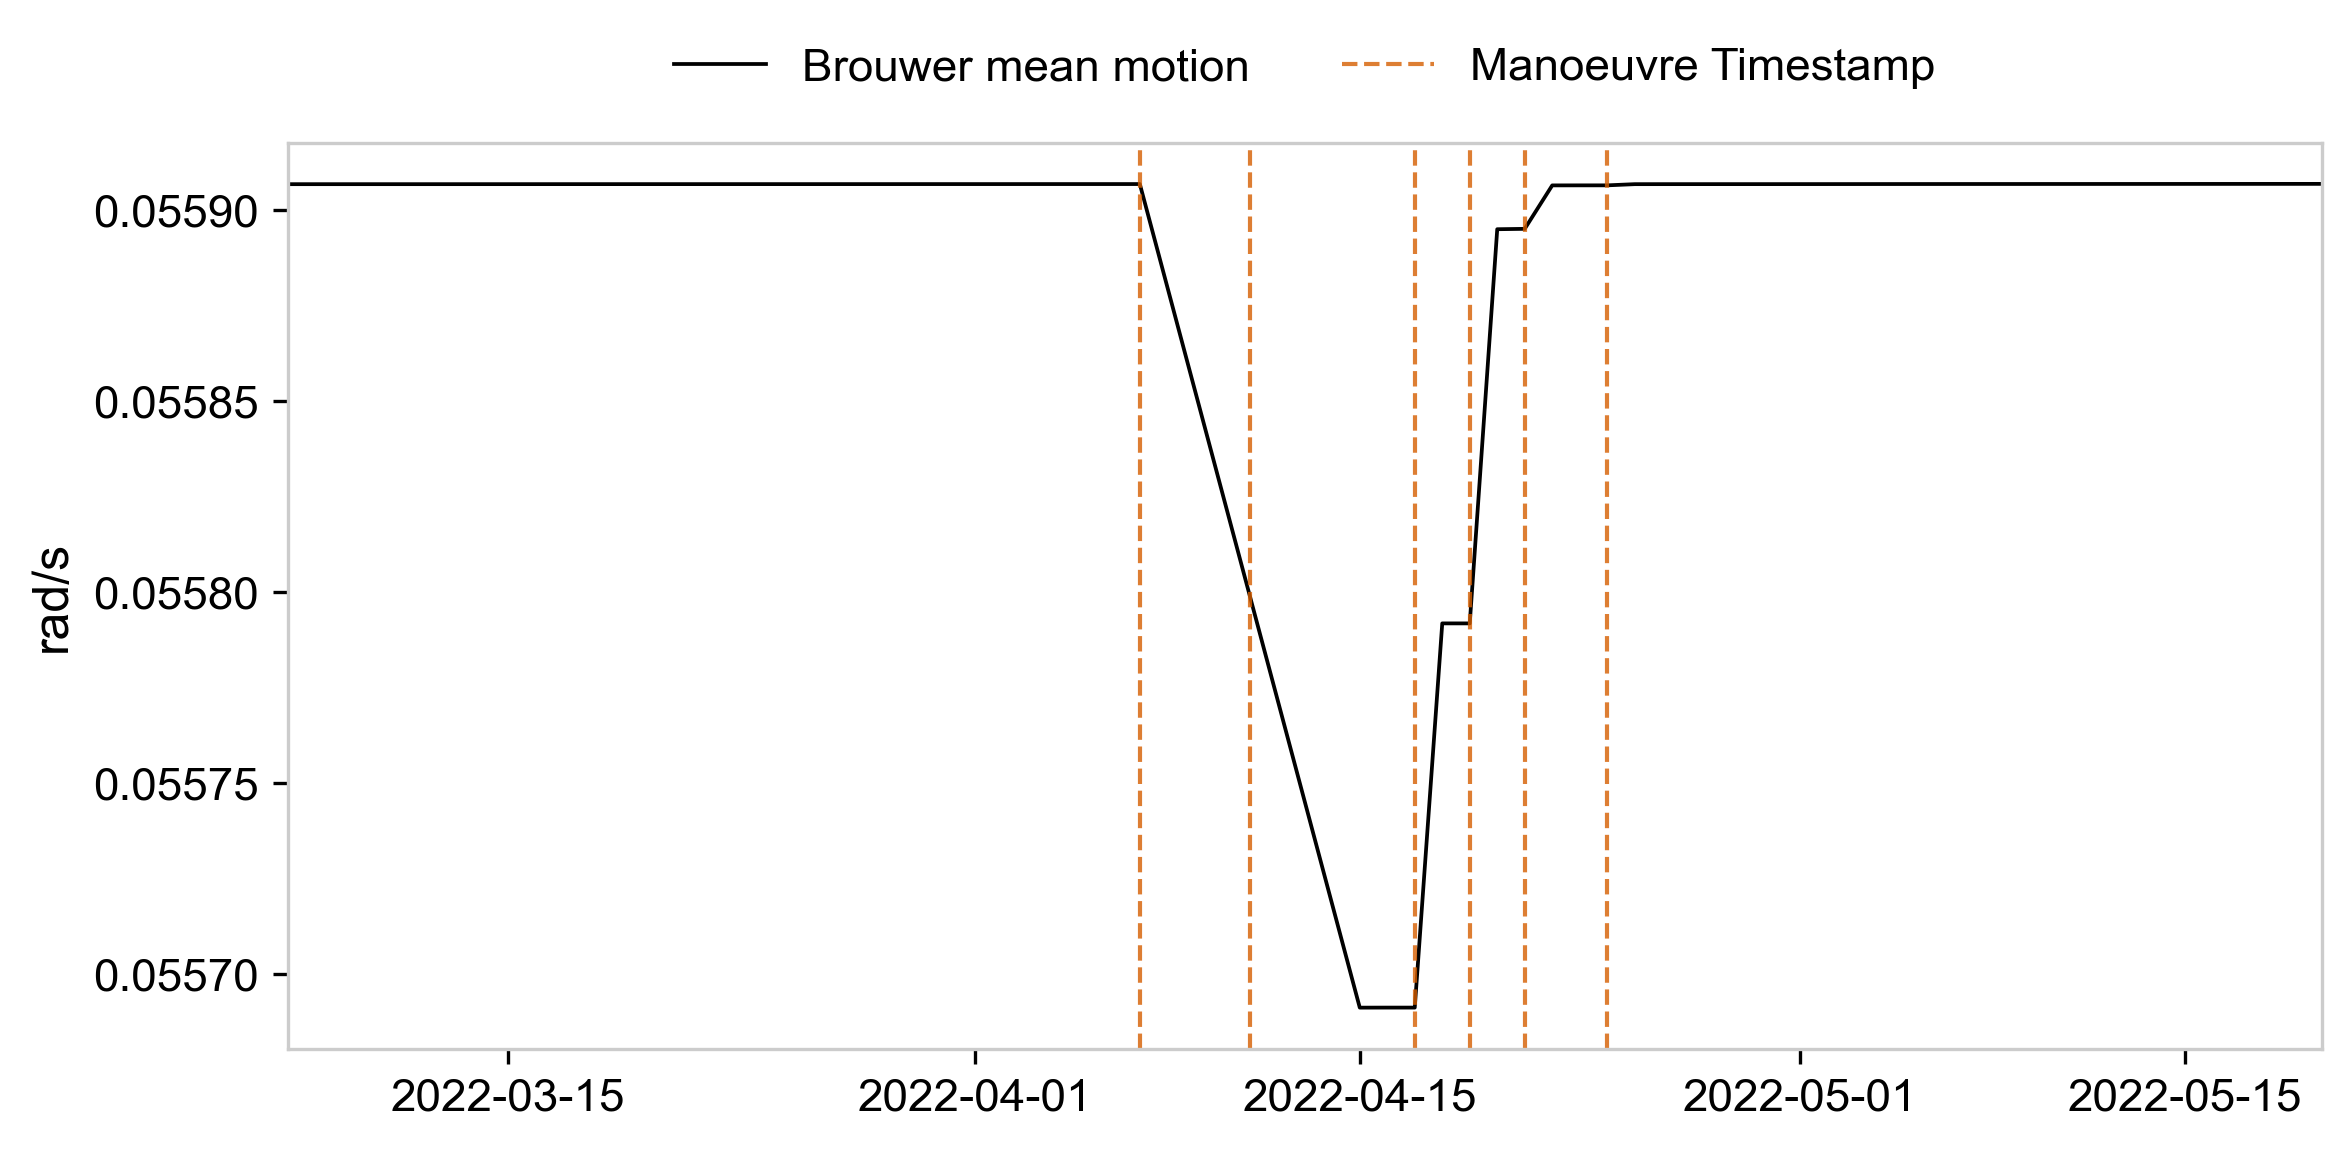

In [31]:
#Consecutive Manuevers
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Jason_3", "Brouwer mean motion", 
                             "2022-03-07","2022-05-20", save_path="Section1_Figure2.png")

Figure saved to figures/F2EA1.png


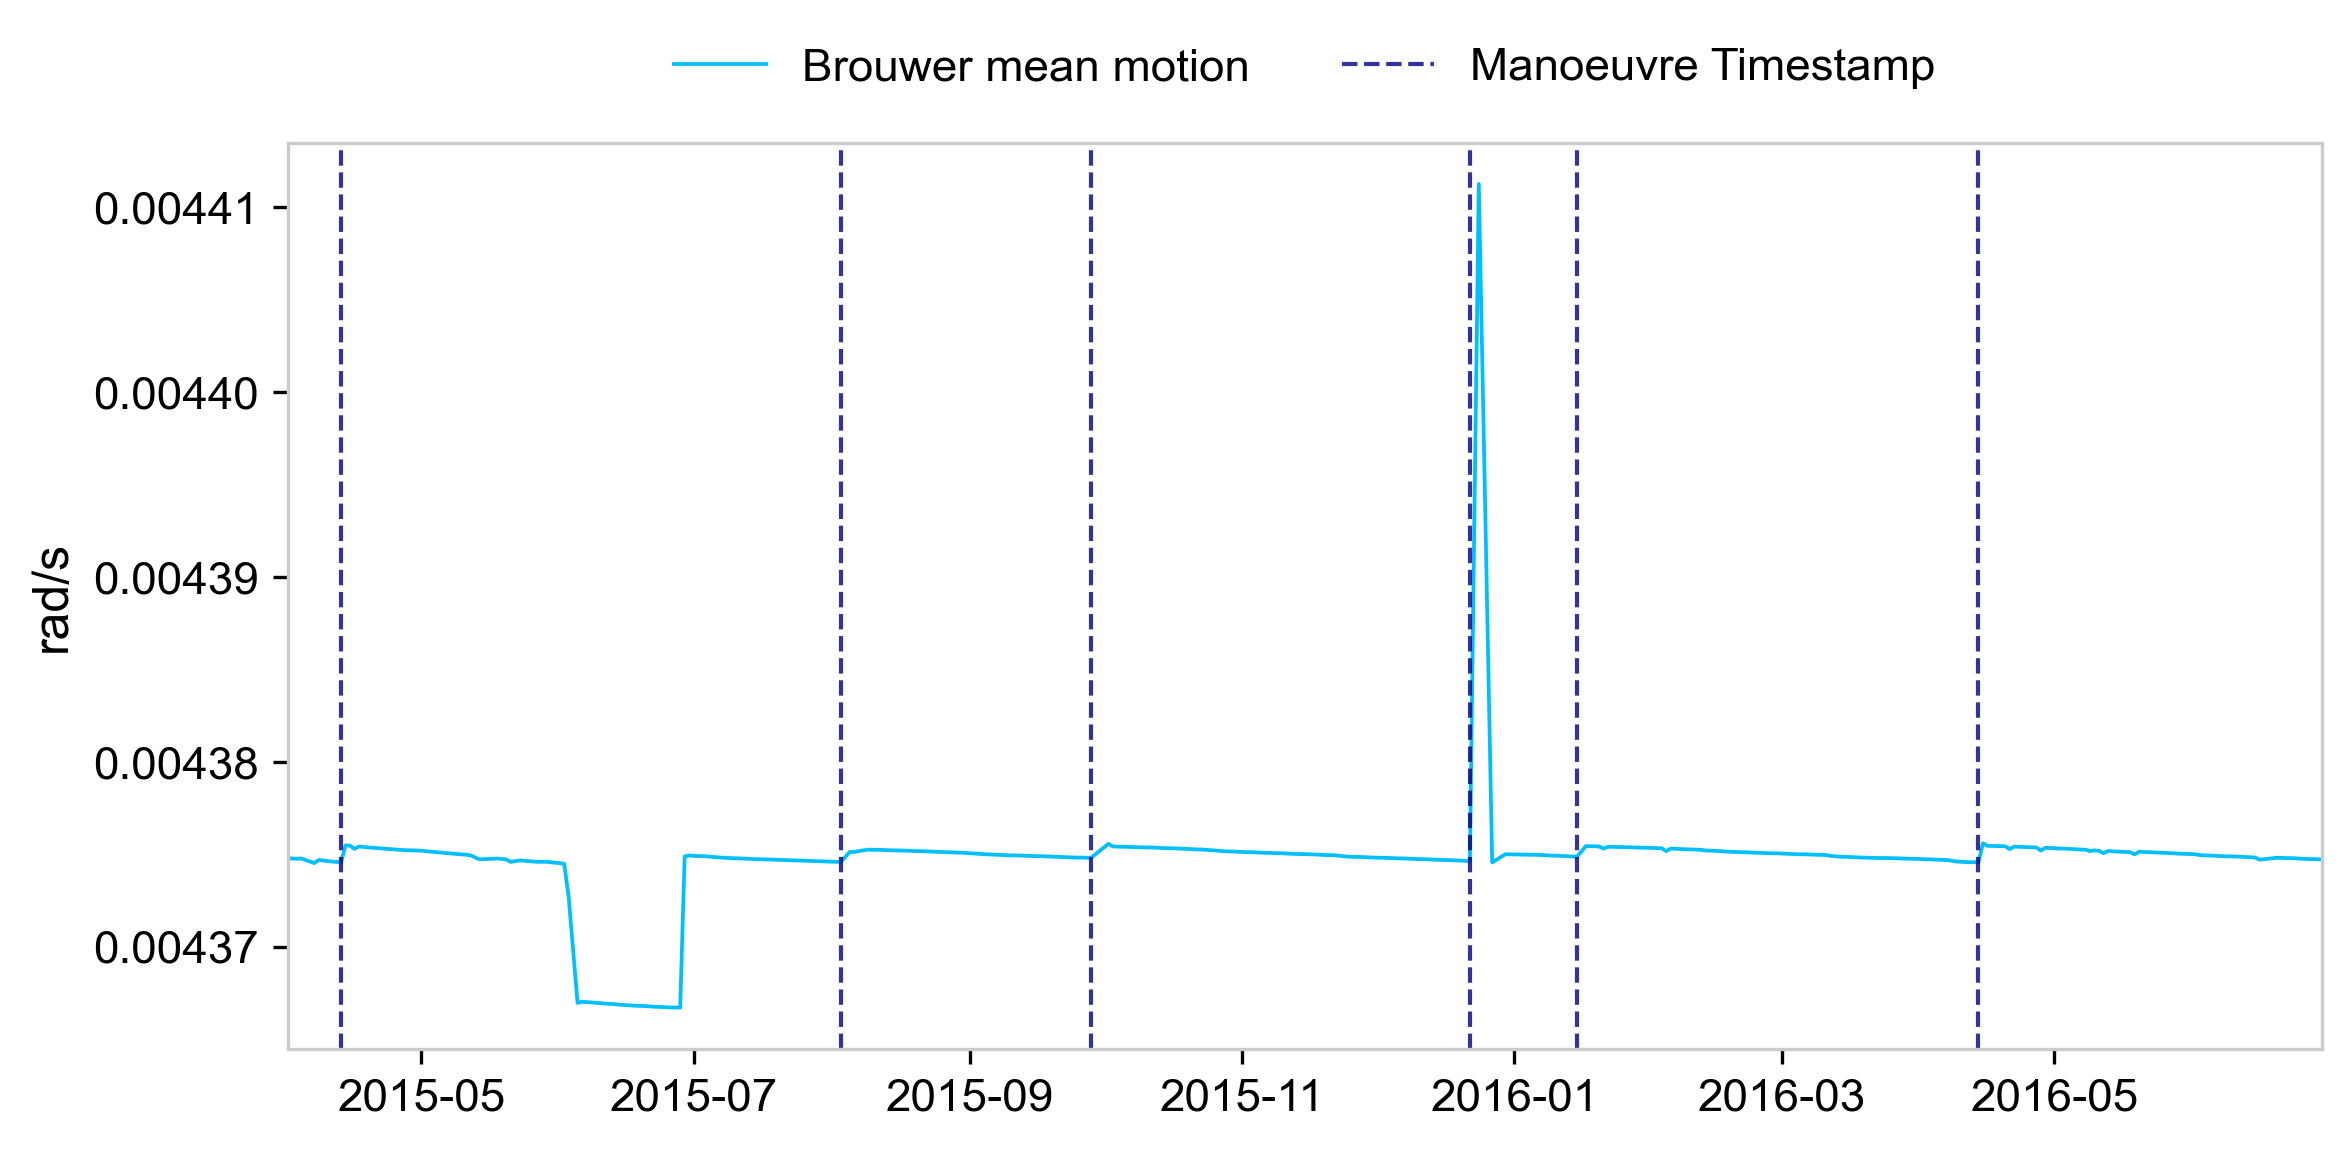

In [524]:
#Extreme Values
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Fengyun_2E", "Brouwer mean motion","2015-04-01","2016-06-30", save_path="figures/F2EA1.png")

Figure saved to Section 3 Figure 3


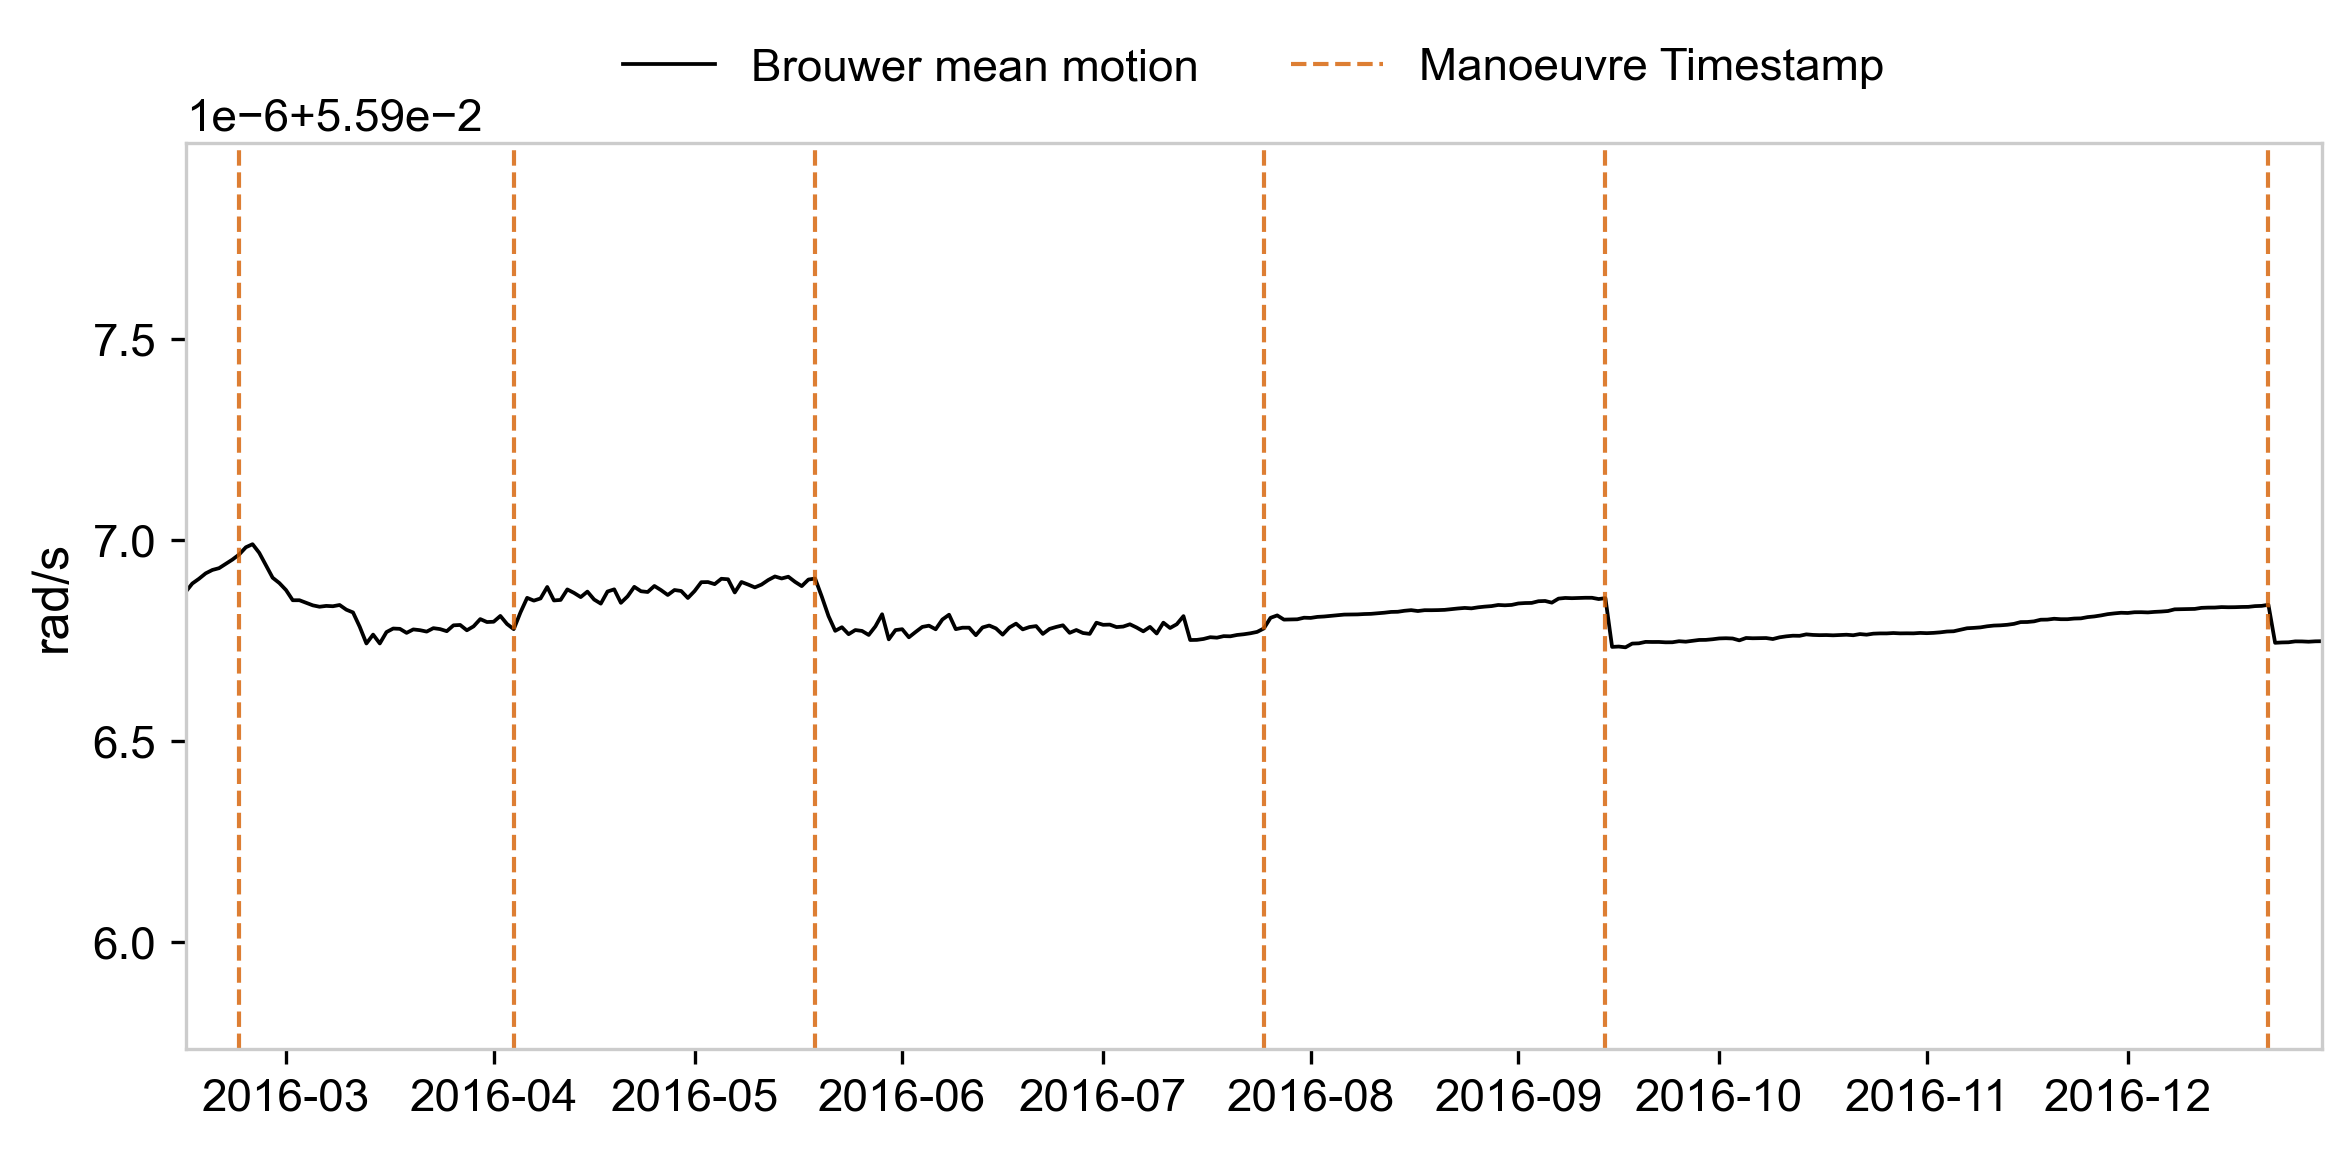

In [43]:
#Drift
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Jason_3", "Brouwer mean motion","2016-02-15","2016-12-30", save_path="Section 3 Figure 3")

Figure saved to figures/acfJason.png


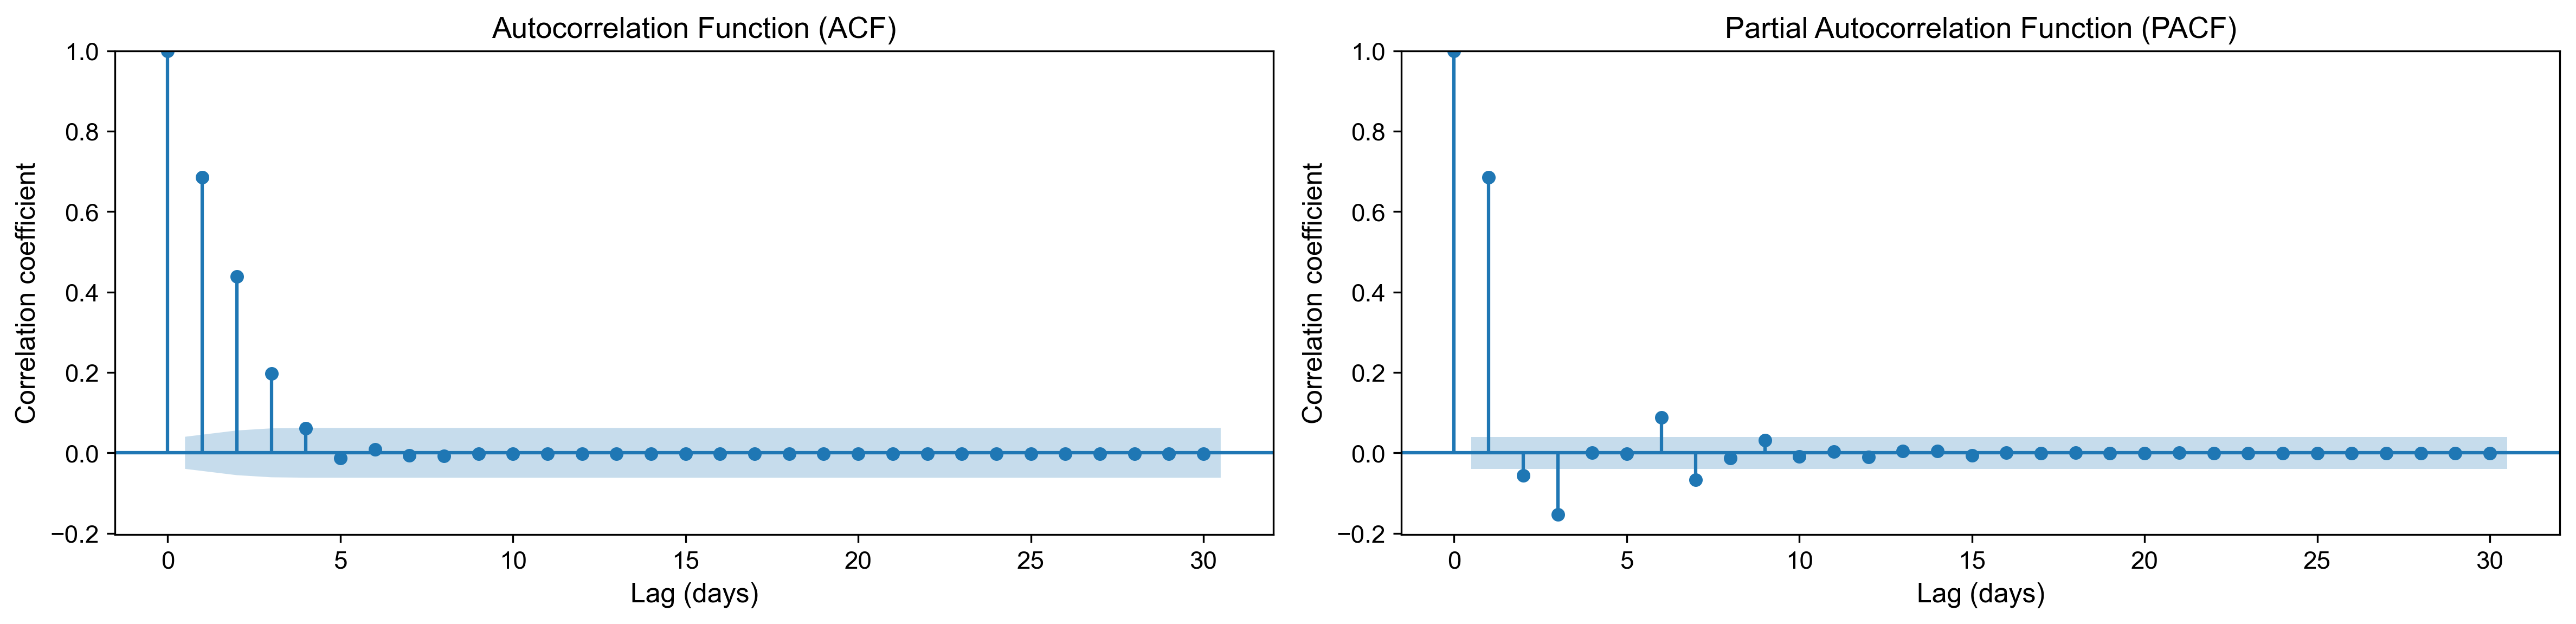

In [621]:
plot_acf_pacf(df_orbital, "Jason_3", "Brouwer mean motion",save_path="figures/acfJason.png",lags=30)

Figure saved to figures/acf4A.png


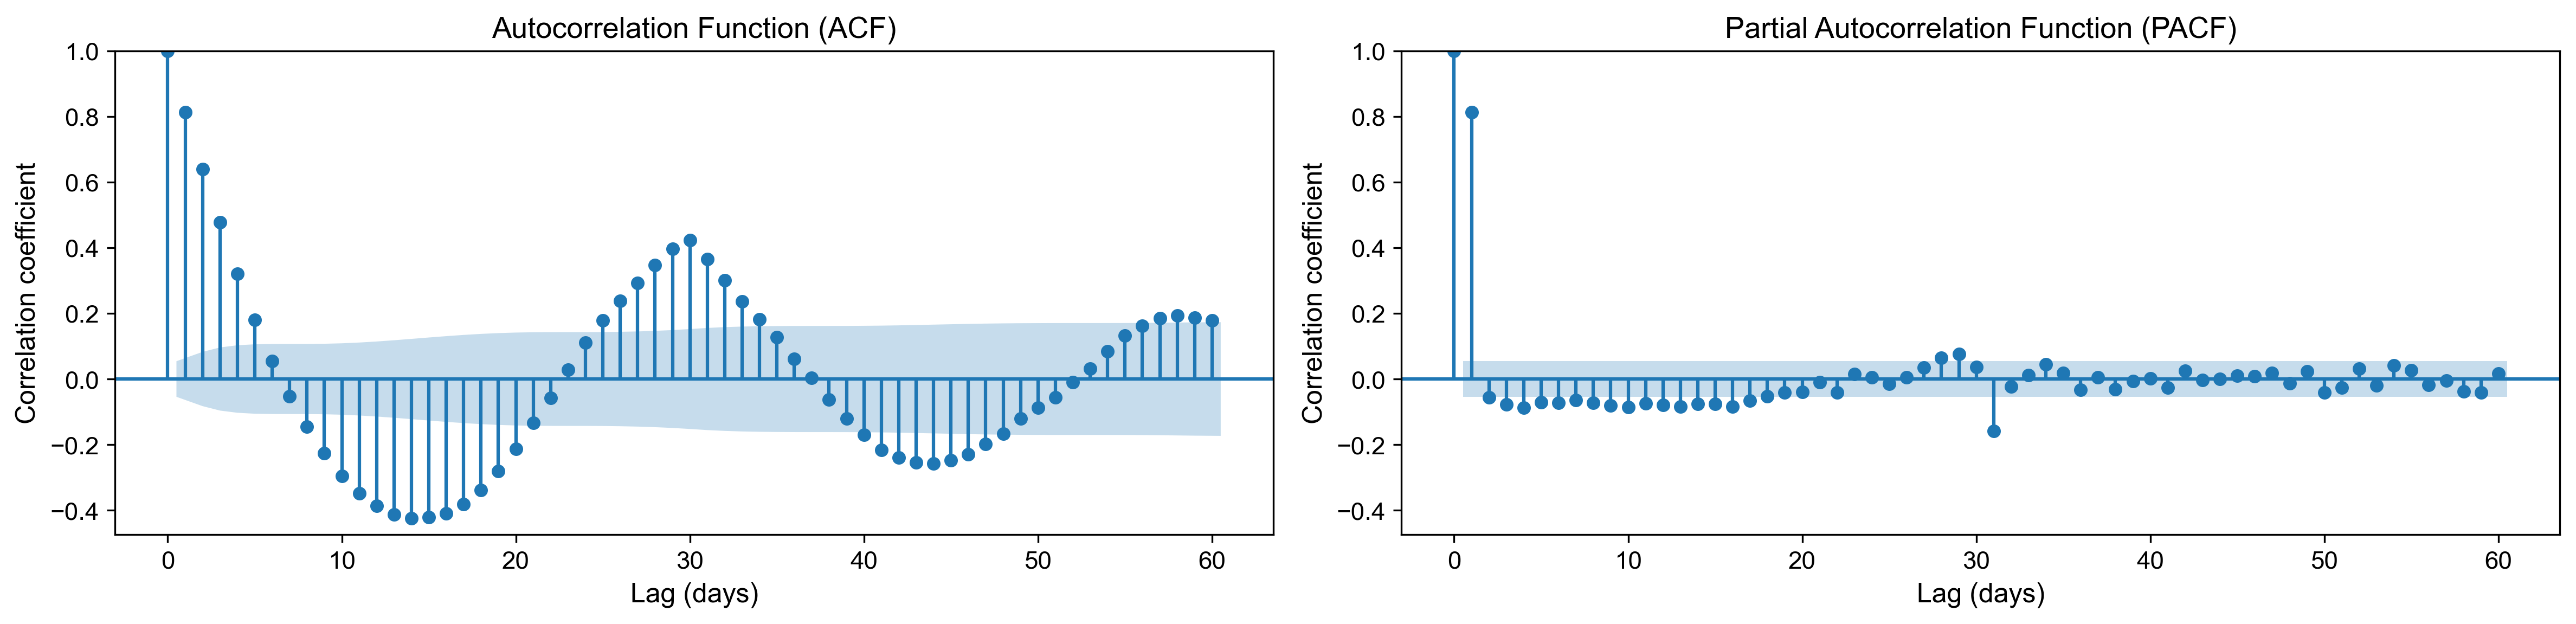

In [627]:
plot_acf_pacf(df_orbital, "Fengyun_4A", "Brouwer mean motion",save_path="figures/acf4A.png",lags=60)